In [ ]:
##########################################################
# DSC5103 Statistics
# Session 10. Trees II: Bagging, Random Forest, and GBM
# 2016.12
#
# Fitting Regression Trees, Bagging, Random Forest, and Gradient Boosting Machine
# demo for Regression problems
# using the Boston housing dataset in package "MASS"
##########################################################

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz

%matplotlib inline

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error

In [2]:
boston_df = pd.read_csv('Boston.csv')
X = boston_df.drop('medv', axis=1)
y = boston_df.medv
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=0)

In [3]:
## bagging
# bagging is simply a special case of a random forest with m=p
regr1 = RandomForestRegressor(n_estimators=500, max_features=13, random_state=1)
regr1.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=13, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

15.91459427399211

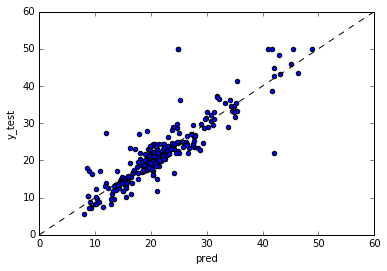

In [4]:
pred = regr1.predict(X_test)
plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')
mean_squared_error(y_test, pred)

In [5]:
## random forests
# random forests: using 6 features
regr2 = RandomForestRegressor(n_estimators=500, max_features=5, random_state=1)
regr2.fit(X_train, y_train)

predrf = regr2.predict(X_test)
mean_squared_error(y_test, predrf)

15.568540433992128

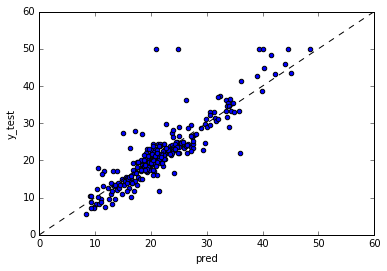

In [6]:
plt.scatter(predrf, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

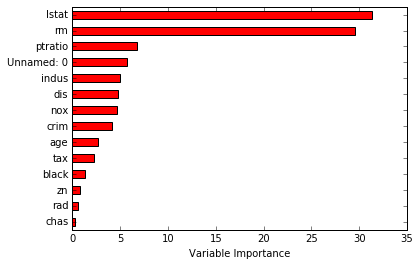

In [7]:
# variable importance
Importance = pd.DataFrame({'Importance':regr2.feature_importances_*100}, index=X.columns)
Importance.sort_values(by='Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [8]:
# tune random forest (mtry) manually
RANDOM_STATE = 1
mtry = np.arange(1, 13.1, 1, dtype='int_')
ooberr = np.zeros(13)
for m in mtry:
    rf = RandomForestRegressor(n_estimators=500, max_features=m, random_state=RANDOM_STATE, oob_score=True)
    rf.fit(X_train, y_train)
    oob_error = 1 - rf.oob_score_    #use out-of-bag samples to estimate the R^2 on unseen data
    ooberr[m-1] = oob_error

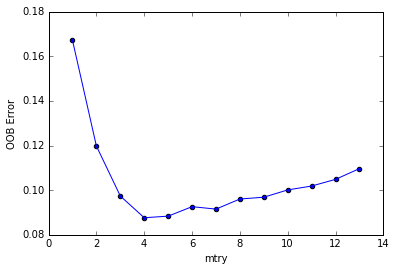

In [9]:
plt.plot(mtry, ooberr)
plt.scatter(mtry, ooberr)
plt.xlabel('mtry')
plt.ylabel('OOB Error')

In [10]:
# optimal mtry
mtry_opt = mtry[np.argmin(ooberr)]
print(mtry_opt)
# optimal oobe
oobe_opt = np.min(ooberr)
print(oobe_opt)

4
0.0876490943291


In [11]:
# random forests: using optimal number of features
regr3 = RandomForestRegressor(n_estimators=500, max_features=mtry_opt, random_state=1)
regr3.fit(X_train, y_train)

predbest = regr2.predict(X_test)
mean_squared_error(y_test, predbest)

15.568540433992128

In [12]:
### Boosting
# fit a boosting model
boston_gbm = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.001, max_depth=4, random_state=1)
boston_gbm.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.001,
             loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=5000,
             presort='auto', random_state=1, subsample=1.0, verbose=0,
             warm_start=False)

In [13]:
predgbm = boston_gbm.predict(X_test)
mean_squared_error(y_test, predgbm)

17.676740213468644

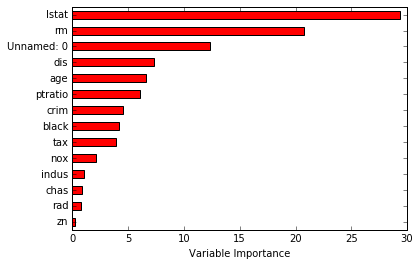

In [14]:
feature_importance = boston_gbm.feature_importances_*100
rel_imp = pd.Series(feature_importance, index=X.columns).sort_values(inplace=False)
rel_imp.T.plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [83]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.grid_search import GridSearchCV

In [84]:
scorer = make_scorer(mean_squared_error, 
                     greater_is_better=False)

In [86]:
boston_reg = GradientBoostingRegressor()

In [87]:
parameters = {"learning_rate": [0.01, 0.005, 0.001, 0.0005], 'max_depth': [1, 2, 4, 6, 8], 'n_estimators': [1000, 2000, 4000, 5000]}

In [88]:
gs = GridSearchCV(boston_reg, param_grid=parameters, scoring=scorer, n_jobs=4, cv=10)

In [89]:
gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'max_depth': [1, 2, 4, 6, 8], 'n_estimators': [1000, 2000, 4000, 5000], 'learning_rate': [0.01, 0.005, 0.001, 0.0005]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=0)

In [92]:
print("BEST", gs.best_params_, gs.best_score_) # gs.best_params_, gs.best_score_, gs.grid_scores_

BEST {'max_depth': 2, 'n_estimators': 5000, 'learning_rate': 0.005} -8.57389099083


In [93]:
gs.grid_scores_

[mean: -15.93594, std: 6.08143, params: {'max_depth': 1, 'n_estimators': 1000, 'learning_rate': 0.01},
 mean: -15.19113, std: 5.98242, params: {'max_depth': 1, 'n_estimators': 2000, 'learning_rate': 0.01},
 mean: -15.31758, std: 6.56447, params: {'max_depth': 1, 'n_estimators': 4000, 'learning_rate': 0.01},
 mean: -15.35575, std: 6.59436, params: {'max_depth': 1, 'n_estimators': 5000, 'learning_rate': 0.01},
 mean: -9.44979, std: 3.52683, params: {'max_depth': 2, 'n_estimators': 1000, 'learning_rate': 0.01},
 mean: -8.69428, std: 3.55586, params: {'max_depth': 2, 'n_estimators': 2000, 'learning_rate': 0.01},
 mean: -8.58988, std: 3.70826, params: {'max_depth': 2, 'n_estimators': 4000, 'learning_rate': 0.01},
 mean: -8.62159, std: 3.74625, params: {'max_depth': 2, 'n_estimators': 5000, 'learning_rate': 0.01},
 mean: -10.85333, std: 5.84835, params: {'max_depth': 4, 'n_estimators': 1000, 'learning_rate': 0.01},
 mean: -10.96893, std: 6.13725, params: {'max_depth': 4, 'n_estimators': 2000

In [107]:
boston_gbm2 = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.005, max_depth=2, random_state=1)
boston_gbm2.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.005,
             loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=5000,
             presort='auto', random_state=1, subsample=1.0, verbose=0,
             warm_start=False)

In [108]:
predgbm2 = boston_gbm2.predict(X_test)
mean_squared_error(y_test, predgbm2)

17.050441412251917

In [113]:
# Alternatively
grids = GridSearchCV(boston_reg, param_grid=parameters, scoring='mean_squared_error', n_jobs=4, cv=10)
# Valid options are ['accuracy', 'adjusted_rand_score', 'average_precision', 'f1', 
# 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'log_loss', 'mean_absolute_error', 
# 'mean_squared_error', 'median_absolute_error', 'precision', 'precision_macro', 'precision_micro', 
# 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 
# 'recall_weighted', 'roc_auc']

In [114]:
grids.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'max_depth': [1, 2, 4, 6, 8], 'n_estimators': [1000, 2000, 4000, 5000], 'learning_rate': [0.01, 0.005, 0.001, 0.0005]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [115]:
print("BEST", grids.best_params_, grids.best_score_) # gs.best_params_, gs.best_score_, gs.grid_scores_

BEST {'max_depth': 2, 'n_estimators': 5000, 'learning_rate': 0.005} -8.57128765412
